In [2]:
import os, sys
os.chdir(os.path.abspath('..'))

In [3]:
import json
from tqdm.notebook import tqdm
import numpy as np
import pandas as pd
import torch
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.colors as mcolors
from scipy.linalg import block_diag
sns.set_theme(style="darkgrid")

In [4]:
%load_ext autoreload
%autoreload 2

import src.utils as utils
import src.preprocess_lib as preprocess_lib
from src.vae_models import CVAE
import src.experiment_lib as experiment_lib
from src.user_encoding_lib import *
from src.forecasting_metrics import *
from src.imputation_lib import *
from src.datasets import *

In [5]:
config_dir = 'runs/autoregressive_forecast/gipuzkoa/'
config_folder = 'sweep_Mar27_19-56-37/'
config = json.load(open(config_dir + config_folder +'config.json', 'r'))

In [6]:
# config["data"]["user_embedding_kwargs"]["model_kwargs"]["num_topics"] = 20
# config["data"]["user_embedding_kwargs"]["model_kwargs"]["num_clusters"] = 500
# config["data"]["user_embedding_kwargs"]["model_kwargs"]["reduce_dim"] = True
# config["data"]["user_embedding_kwargs"]["model_kwargs"]["num_lower_dims"] = 24

In [7]:
trainset, valset, conditioner, user_ids, months, _, indices, condition_set, X_test, X_missing, num_missing_days, nonzero_mean, nonzero_std = preprocess_lib.prepare_data(config["data"])
num_steps_per_profile = trainset.inputs.shape[-1]

Dataset: goi4_dp_full_Gipuzkoa
Removing 15 users with all-zero consumption profiles
Removing 67 users with any-negative consumption profiles
Amputation Parameters...................a=0.85, b=None
Found a matching user model in data/goi4_dp_full_Gipuzkoa/user_encoding_models/model_118
Adding 6830 additional missing profiles due to missing condition values.
Re-splitting datasets.
Number of training data.................1495770 (60.00%)
Number of validation data...............491760 (19.73%)
Number of testing data..................498590 (20.00%)
Number of missing data...................6830 (0.27%)


In [8]:
user_model_dir = "data/goi4_dp_full_Gipuzkoa/user_encoding_models/"
user_model_folder = "model_118"
user_model = UserEncoder.load(user_model_dir + user_model_folder)
gamma_matrix = np.load(user_model_dir + user_model_folder + "/user_gamma.npy")

In [9]:
beta_matrix = user_model.lambda_matrix/np.sum(user_model.lambda_matrix, axis=1, keepdims=True)

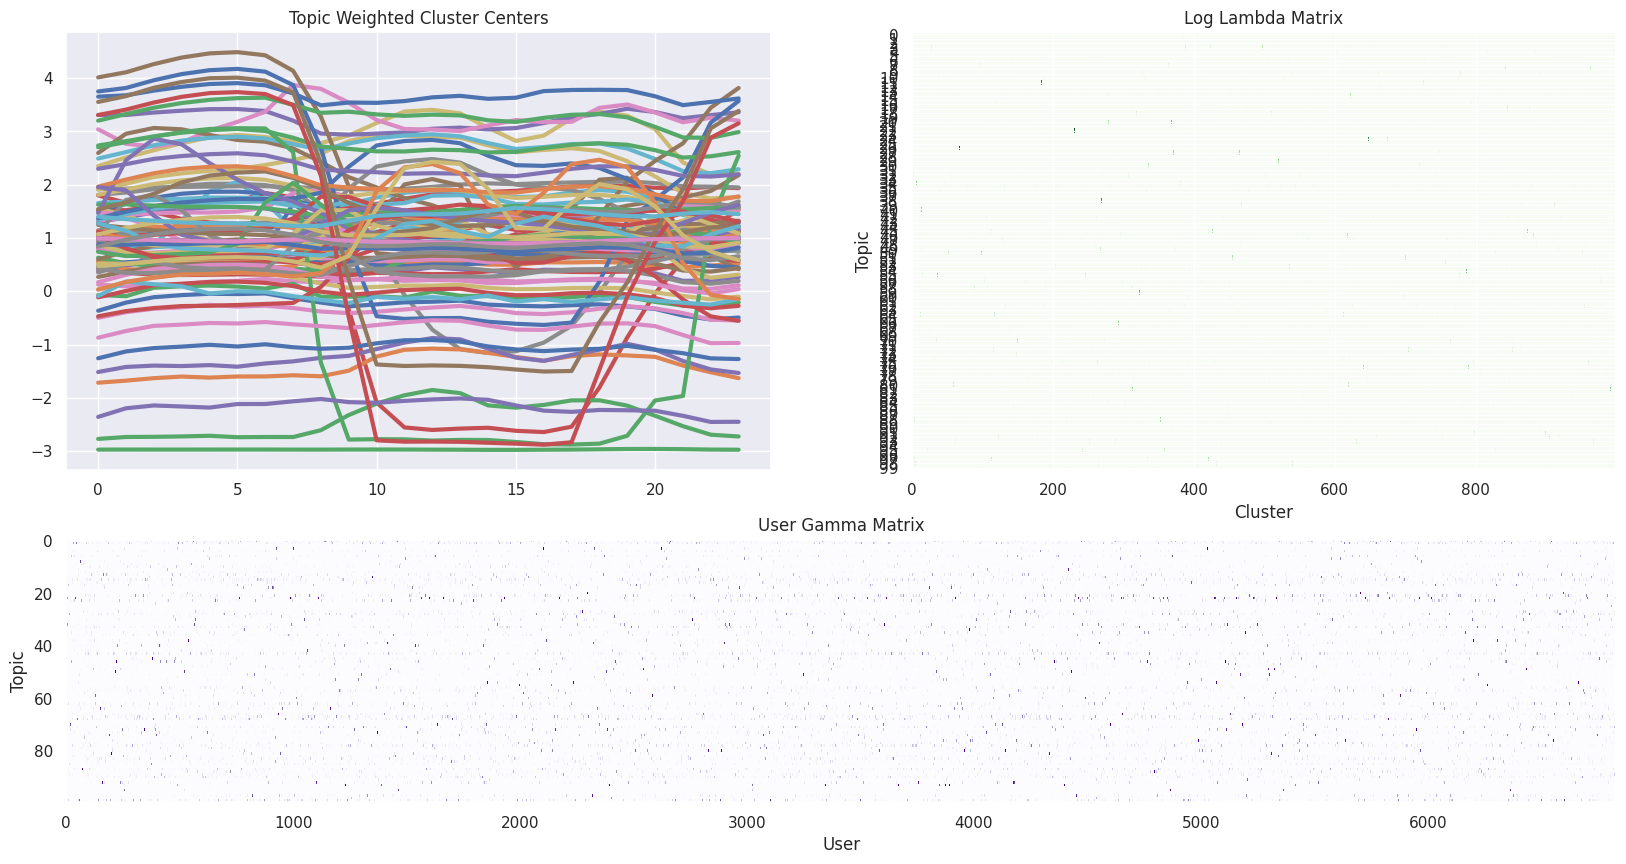

In [19]:
import matplotlib.gridspec as gridspec

fig = plt.figure(figsize=(20, 10))
gs = gridspec.GridSpec(2, 2, height_ratios=[5, 3])
ax_top_left = fig.add_subplot(gs[0, 0])
ax_top_right = fig.add_subplot(gs[0, 1])
ax_bottom = fig.add_subplot(gs[1, :])
ax = [ax_top_left, ax_top_right]  # used by the existing code below
# fig, ax = plt.subplots(1, 2, figsize=(20, 5))
# ax[0].plot((user_model.cluster_centers@user_model.reducer_matrix)[::5].T, alpha=0.5)
ax[0].plot((beta_matrix@user_model.cluster_centers@user_model.reducer_matrix).T, alpha=1.0, lw=3)
ax[0].set_title('Topic Weighted Cluster Centers')
ax[1].imshow((beta_matrix), cmap='Greens', aspect='auto', interpolation='nearest')
ax[1].set_xlabel('Cluster')
ax[1].set_ylabel('Topic')
ax[1].set_title('Log Lambda Matrix')
ax[1].set_yticks(np.arange(user_model.lambda_matrix.shape[0]))
ax_bottom.imshow(gamma_matrix.T, cmap='Purples', aspect='auto', interpolation='nearest')
ax_bottom.set_xlabel('User')
ax_bottom.set_ylabel('Topic')
ax_bottom.set_title('User Gamma Matrix')
plt.grid(False)
plt.show()

In [20]:
empiric_theta_mean = np.mean([conditioner.transformers["users"].transform(gamma_matrix) for _ in range(100)], axis=0)

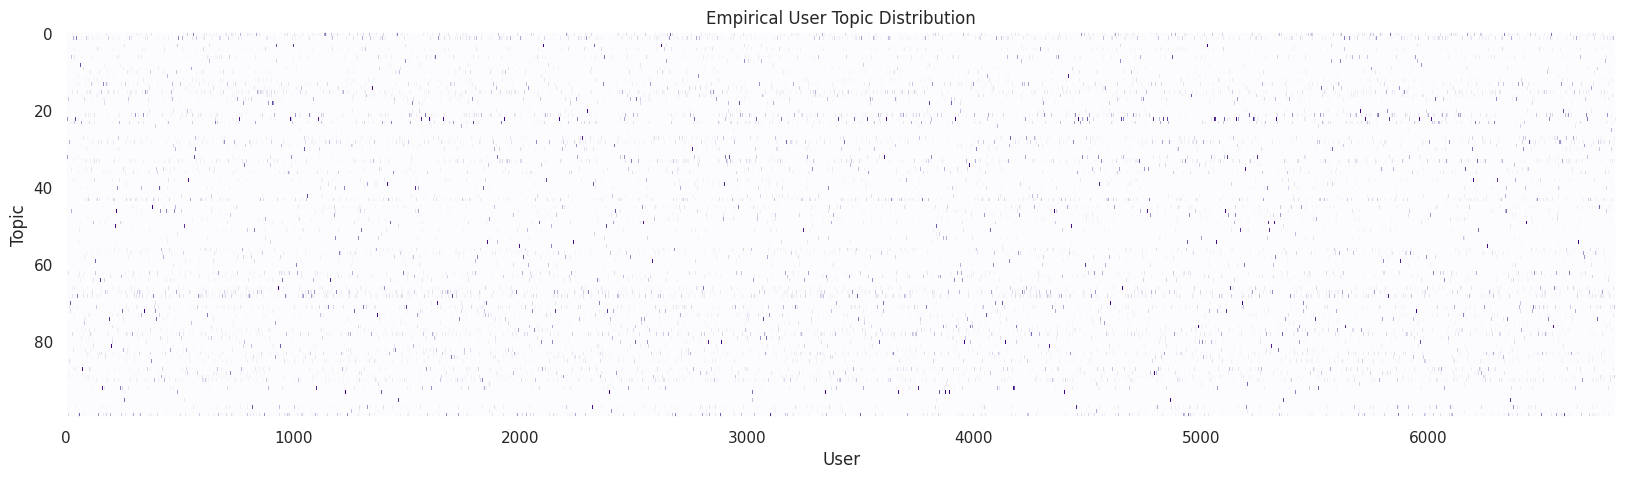

In [21]:
fig, ax = plt.subplots(1, 1, figsize=(20, 5))
ax.imshow(empiric_theta_mean.T, cmap='Purples', aspect='auto', interpolation='nearest')
ax.set_xlabel('User')
ax.set_ylabel('Topic')
ax.set_title('Empirical User Topic Distribution')
plt.grid(False)
plt.show()

In [22]:
model = CVAE(input_dim=trainset.inputs.shape[1], conditioner=conditioner, **config["model"])
model.load(os.path.join(config_dir, config_folder))
model.eval()
pass

USING SIGMA_LIM!
USING SIGMA_LIM!


In [23]:
torch.cuda.empty_cache()
import gc
gc.collect()

23

In [24]:
device = torch.device('cuda:1' if torch.cuda.is_available() else 'cpu')
model.to(device)
model.prior_params = {key: value.to(device) for key, value in model.prior_params.items()}

In [25]:
if config["data"]["dataset_name"] == "goi4_dp_full_Gipuzkoa":
    log_space = config["data"]["scaling"]["log_space"]
    zero_id = config["data"]["scaling"]["zero_id"]
    shift = config["data"]["scaling"]["shift"]
elif config["data"]["dataset_name"] == "STORM_daily": 
    alpha = config["data"]["scaling"]["alpha"]
    zero_id=-np.inf
else: raise ValueError("Unknown dataset")

In [102]:
# user_idx = 3533
user_idx = 2112

In [103]:
test_elements = indices["test"][user_ids["test"] == user_idx]
missing_elements = indices["missing"][user_ids["missing"] == user_idx]
missing_elements = missing_elements[(missing_elements > test_elements[0]) & (missing_elements < test_elements[-1])]
test_idx = test_elements - test_elements[0]
missing_idx = missing_elements - test_elements[0]

test_missing_idx = np.union1d(test_idx, missing_idx)

num_test_days_full = len(test_idx)
num_test_days_missing = len(missing_idx)
num_test_days = len(test_missing_idx)

In [104]:
X_test_user = X_test[user_ids["test"]==user_idx]
conditions_user = {key: val[user_ids["test"]==user_idx] for key, val in condition_set["test"].items()}
# test_conditions = torch.tensor(conditioner.transform(conditions_user).astype(np.float32)).to(device)
testset = ConditionedDataset(X_test_user, conditions_user, conditioner)

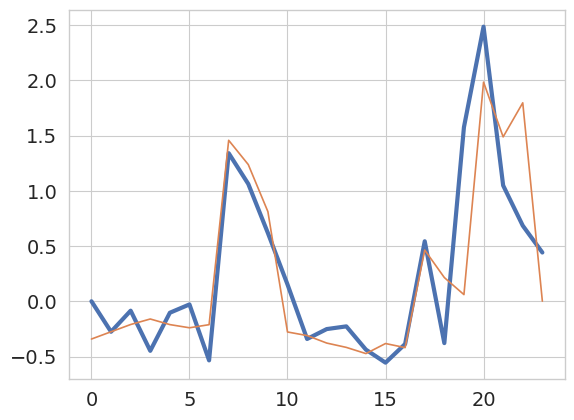

In [105]:
plt.plot(X_test_user[2], lw=3)
plt.plot(conditions_user["day_befores"][2])
try:
    plt.plot(conditions_user["twoday_befores"][2])
except:
    pass
try:
    plt.plot(conditions_user["week_befores"][2])
except:
    pass
plt.show()

In [106]:
X_missing_user = X_missing[np.isin(indices["missing"], missing_elements)]
conditions_missing_user = {key: val[np.isin(indices["missing"], missing_elements)] for key, val in condition_set["missing"].items()}
missing_conditions = torch.tensor(conditioner.transform(conditions_missing_user).astype(np.float32)).to(device)

In [107]:
X_test_missing_user = np.ndarray((num_test_days, X_test_user.shape[1]))
X_test_missing_user[test_idx] = X_test_user
X_test_missing_user[missing_idx] = X_missing_user

In [108]:
num_prior_samples = 1000
test_batch_size = 2**8

testset.num_samples = num_prior_samples

test_loader = torch.utils.data.DataLoader(testset, batch_size=test_batch_size, shuffle=False)

# num_batches = int(np.ceil(num_test_days_full / test_batch_size))
estimation_params = {"mu":torch.zeros(num_prior_samples, num_test_days, model.input_dim)*np.nan, "sigma":torch.zeros(num_prior_samples, num_test_days, model.decoder.parameterizer.block_dict["sigma"].output_dim)*np.nan}
estimation_samples = torch.zeros(num_prior_samples, num_test_days, model.input_dim)*np.nan
log_likelihoods = torch.zeros(num_prior_samples, num_test_days)*np.nan

In [109]:
with torch.no_grad():
    acc = 0
    for i, inputs in enumerate(test_loader):

        x_test_batch, conditions_test_batch = model.move_to_device(inputs, device)
        estimation = model.sample(conditions_test_batch, num_samples_prior=num_prior_samples)
        estimation_params["mu"][:, acc:acc+len(x_test_batch), :] = estimation["params"]["mu"].detach().cpu()
        estimation_params["sigma"][:, acc:acc+len(x_test_batch), :] = estimation["params"]["sigma"].detach().cpu()
        estimation_samples[:, acc:acc+len(x_test_batch), :] = estimation["samples"].squeeze(0).detach().cpu()
        log_likelihoods[:, acc:acc+len(x_test_batch)] = model.decoder.log_likelihood(x_test_batch, estimation["params"]).detach().cpu()
        acc += len(x_test_batch)


In [110]:
estimation_params["mu"] = estimation_params["mu"].numpy()
estimation_params["sigma"] = estimation_params["sigma"].numpy()
estimation_samples = estimation_samples.numpy()
log_likelihoods = log_likelihoods.numpy()

In [132]:
quantiles = [0.05, 0.10, 0.15, 0.20, 0.25, 0.35, 0.45, 0.50, 0.55, 0.65, 0.75, 0.80, 0.85, 0.90, 0.95]
# quantiles = np.arange(0.05, 0.95, 0.01)

In [133]:
quantiles_test = np.quantile(np.maximum(estimation_samples,zero_id), quantiles, axis=0)
quantiles_test = quantiles_test.reshape(len(quantiles), 1, -1)

In [148]:
start_day = 20
end_day = 29

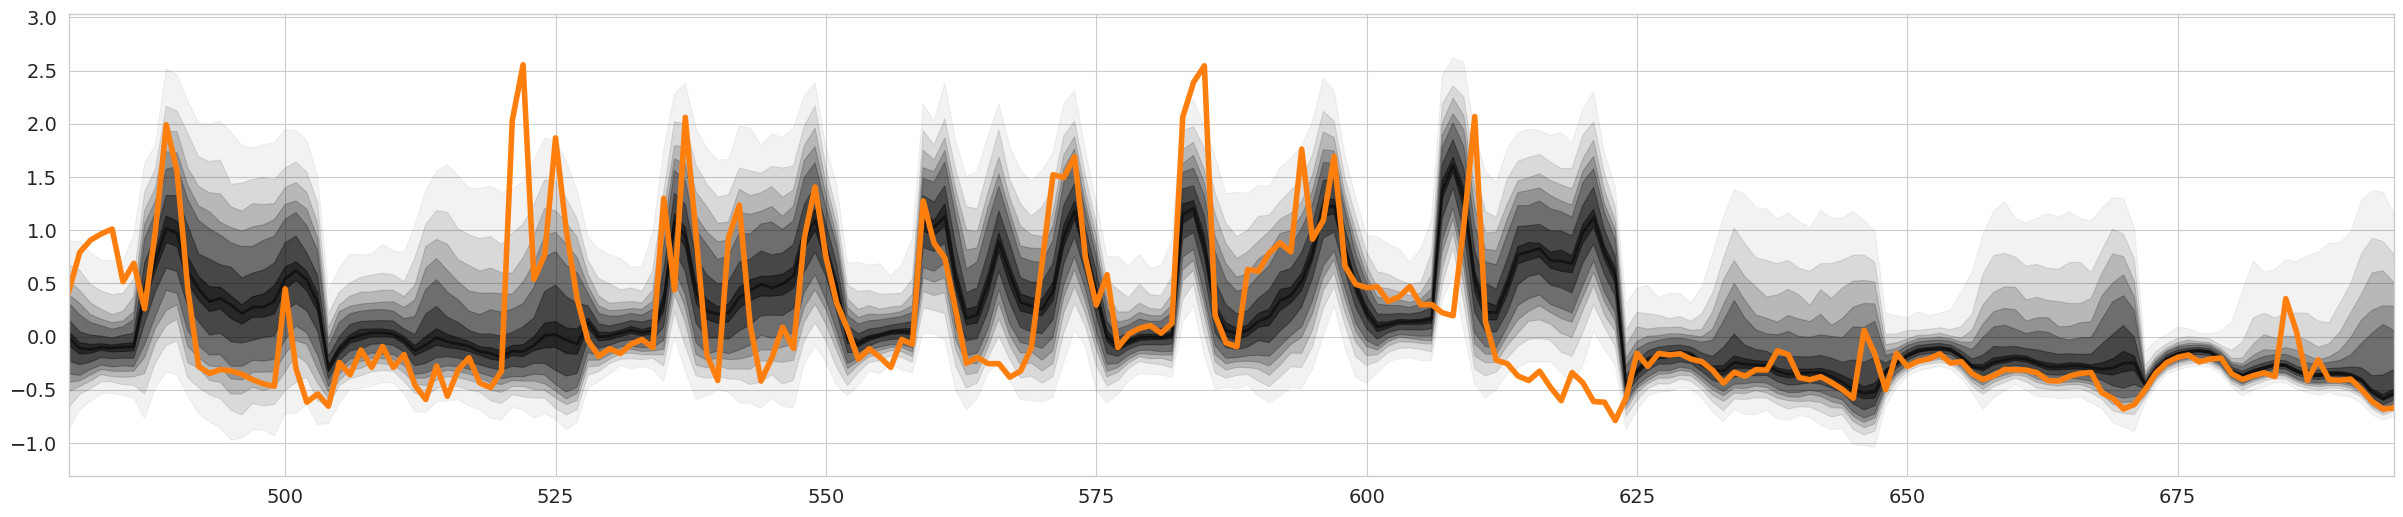

In [149]:
fig, ax = plt.subplots(figsize=(30, 6))
for i in range(quantiles.__len__()//2):
    ax.fill_between(np.arange(quantiles_test.shape[-1]),quantiles_test[i,0,:], quantiles_test[-(i+1),0,:], alpha=1*quantiles[i], color="black")
ax.plot(quantiles_test[quantiles.__len__()//2,0,:], label="Predicted", color="black", lw=2, alpha=0.5)

ax.plot(X_test_missing_user.flatten(), label="True", lw=4, alpha=1.0, color="tab:orange")
# ax.set_yscale("log")

plt.xlim(X_test.shape[-1]*start_day, X_test.shape[-1]*end_day-1)
plt.show()

In [150]:
pbar = tqdm(total=num_prior_samples)

for i in range(num_test_days_missing):
    
    x_test = torch.tensor(X_missing_user[[i]]).to(device)

    condition = {k: v[[i]] for k,v in conditions_missing_user.items()}

    missing_condition = False

    if np.isnan(condition["day_befores"]).any():
        missing_condition = True
        x_day_before = condition["day_befores"]
        x_day_before_samples, _, _ = cvae_imputation(model, x_day_before, conditioner=conditioner, condition_set={k: v[[i-1]] for k,v in conditions_missing_user.items()}, num_samples=num_prior_samples, num_iter=0, warmup_steps=2500, verbose_freq=100, device=device)

    for j in range(num_prior_samples):
        pbar.update(1)
        with torch.no_grad():
            if missing_condition: condition["day_befores"] = torch.tensor(x_day_before_samples[j]).float()
            batch_conditions = torch.tensor(conditioner.transform(condition)).float()
            estimation = model.sample(batch_conditions.to(device), num_samples_prior=1)
            estimation_params["mu"][j, missing_idx[i]] = estimation["params"]["mu"].detach().to("cpu")
            estimation_params["sigma"][j, missing_idx[i]] = estimation["params"]["sigma"].detach().to("cpu")
            estimation_samples[j, missing_idx[i]] = estimation["samples"].detach().squeeze(0).to("cpu")
            try:
                log_likelihoods[j, missing_idx[i]] = model.decoder.log_likelihood(x_test, estimation["params"]).detach().to("cpu").float()
            except:
                pass

  0%|          | 0/1000 [00:00<?, ?it/s]

In [151]:
plt.step(np.arange(num_steps_per_profile),x_day_before_samples[:,0,:].T, alpha=0.1)
plt.show()

NameError: name 'x_day_before_samples' is not defined

In [ ]:
quantiles_test = np.quantile(np.maximum(estimation_samples,zero_id), quantiles, axis=0)
quantiles_test = quantiles_test.reshape(len(quantiles), 1, -1)

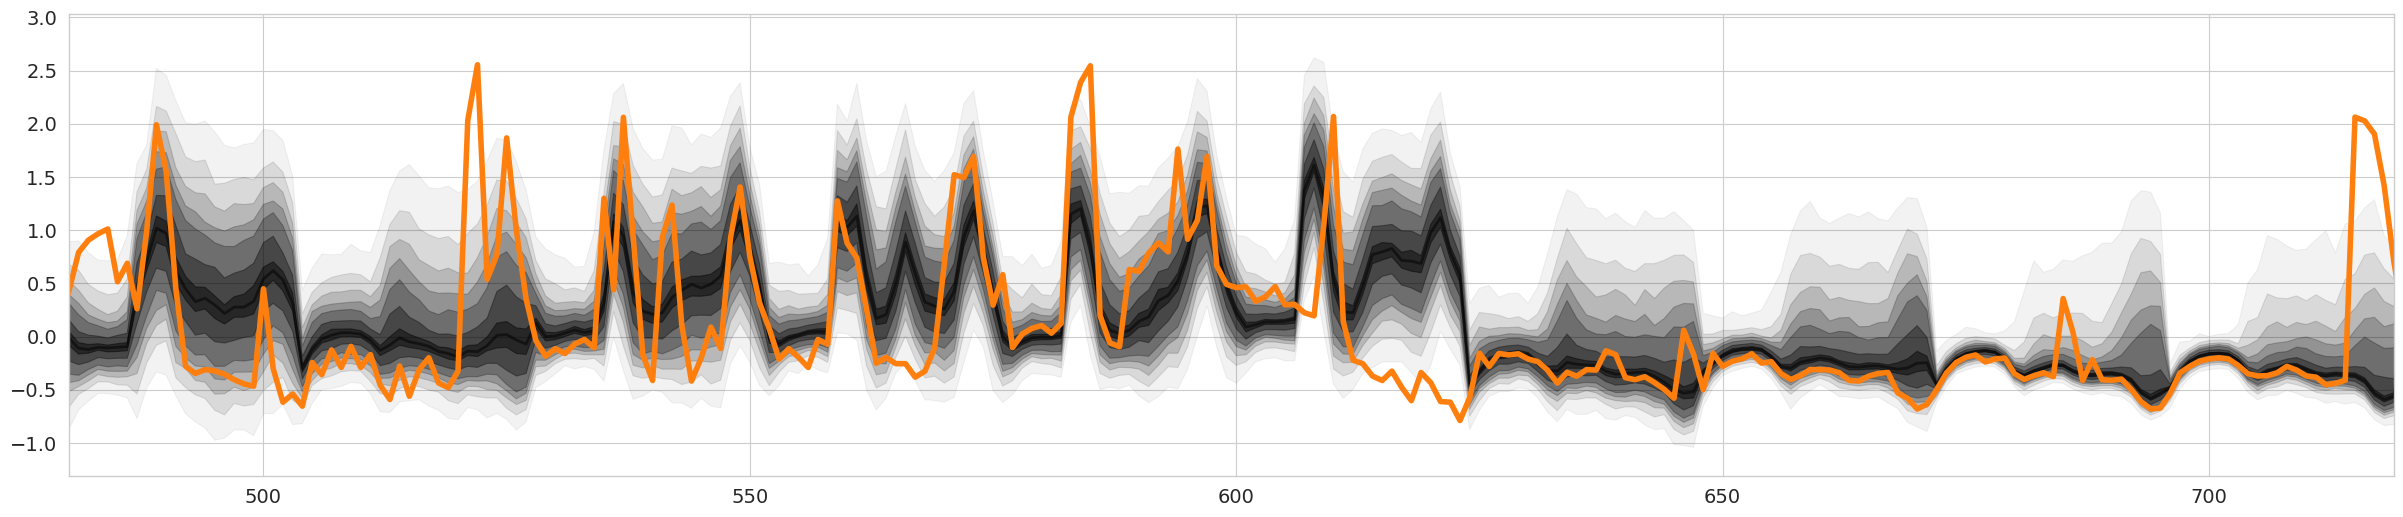

In [ ]:
fig, ax = plt.subplots(figsize=(30, 6))
for i in range(quantiles.__len__()//2):
    ax.fill_between(np.arange(quantiles_test.shape[-1]),quantiles_test[i,0,:], quantiles_test[-(i+1),0,:], alpha=1*quantiles[i], color="black")
ax.plot(quantiles_test[quantiles.__len__()//2,0,:], label="Predicted", color="black", lw=2, alpha=0.5)

ax.plot(X_test_missing_user.flatten(), label="True", lw=4, alpha=1.0, color="tab:orange")
# ax.set_yscale("log")

plt.xlim(X_test.shape[-1]*start_day, X_test.shape[-1]*end_day-1)
plt.show()

In [ ]:
log_likelihoods = log_likelihoods.reshape(num_prior_samples, 1, num_test_days)
closest_idx = np.argsort(log_likelihoods, axis=0)[::-1]

In [ ]:
norm = 2
distances = np.power(np.nanmean(np.power(np.reshape(estimation_samples - X_test_missing_user, (num_prior_samples, num_test_days, -1)), norm), axis=-1), 1/norm).reshape(num_prior_samples, 1, num_test_days)
closest_idx_distance = np.argsort(distances, axis=0)

In [152]:
num_viz_samples = 1
best_indices = closest_idx[:num_viz_samples,0,:]
median_best_indices = closest_idx[(num_prior_samples-num_viz_samples)//2:(num_prior_samples+num_viz_samples)//2,0,:]
best_indices_distance = closest_idx_distance[:num_viz_samples,0,:]
median_best_indices_distance = closest_idx_distance[(num_prior_samples-num_viz_samples)//2:(num_prior_samples+num_viz_samples)//2,0,:]

In [153]:
with torch.no_grad():
    cov_matrices_median = model.decoder.create_covariance_matrix({"mu": torch.tensor(estimation_params["mu"]).to(device), "sigma": torch.tensor(np.take_along_axis(estimation_params["sigma"][:], median_best_indices[...,None], axis=0)).to(device)}).cpu().numpy()
    cov_matrices_best = model.decoder.create_covariance_matrix({"mu": torch.tensor(estimation_params["mu"]).to(device), "sigma": torch.tensor(np.take_along_axis(estimation_params["sigma"][:], best_indices[...,None], axis=0)).to(device)}).cpu().numpy()
    marginal_sigmas_median = np.sqrt(np.diagonal(cov_matrices_median, axis1=-2, axis2=-1))
    marginal_sigmas_best = np.sqrt(np.diagonal(cov_matrices_best, axis1=-2, axis2=-1))
    corr_matrices_median = cov_matrices_median / (marginal_sigmas_median[...,:,None,:] * marginal_sigmas_median[...,None])
    corr_matrices_best = cov_matrices_best / (marginal_sigmas_best[...,:,None,:] * marginal_sigmas_best[...,None])

In [154]:
devs = [0.25, 0.5, 1, 1.5, 2]

dependency_lookaway = 6

In [155]:
sns.set_theme(context="paper", style="whitegrid", font_scale=1.6)

/tmp/ipykernel_1990298/2043571788.py:69: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout(rect=[0, 0.1, 1, 1])  # Adjust layout to accommodate colorbar


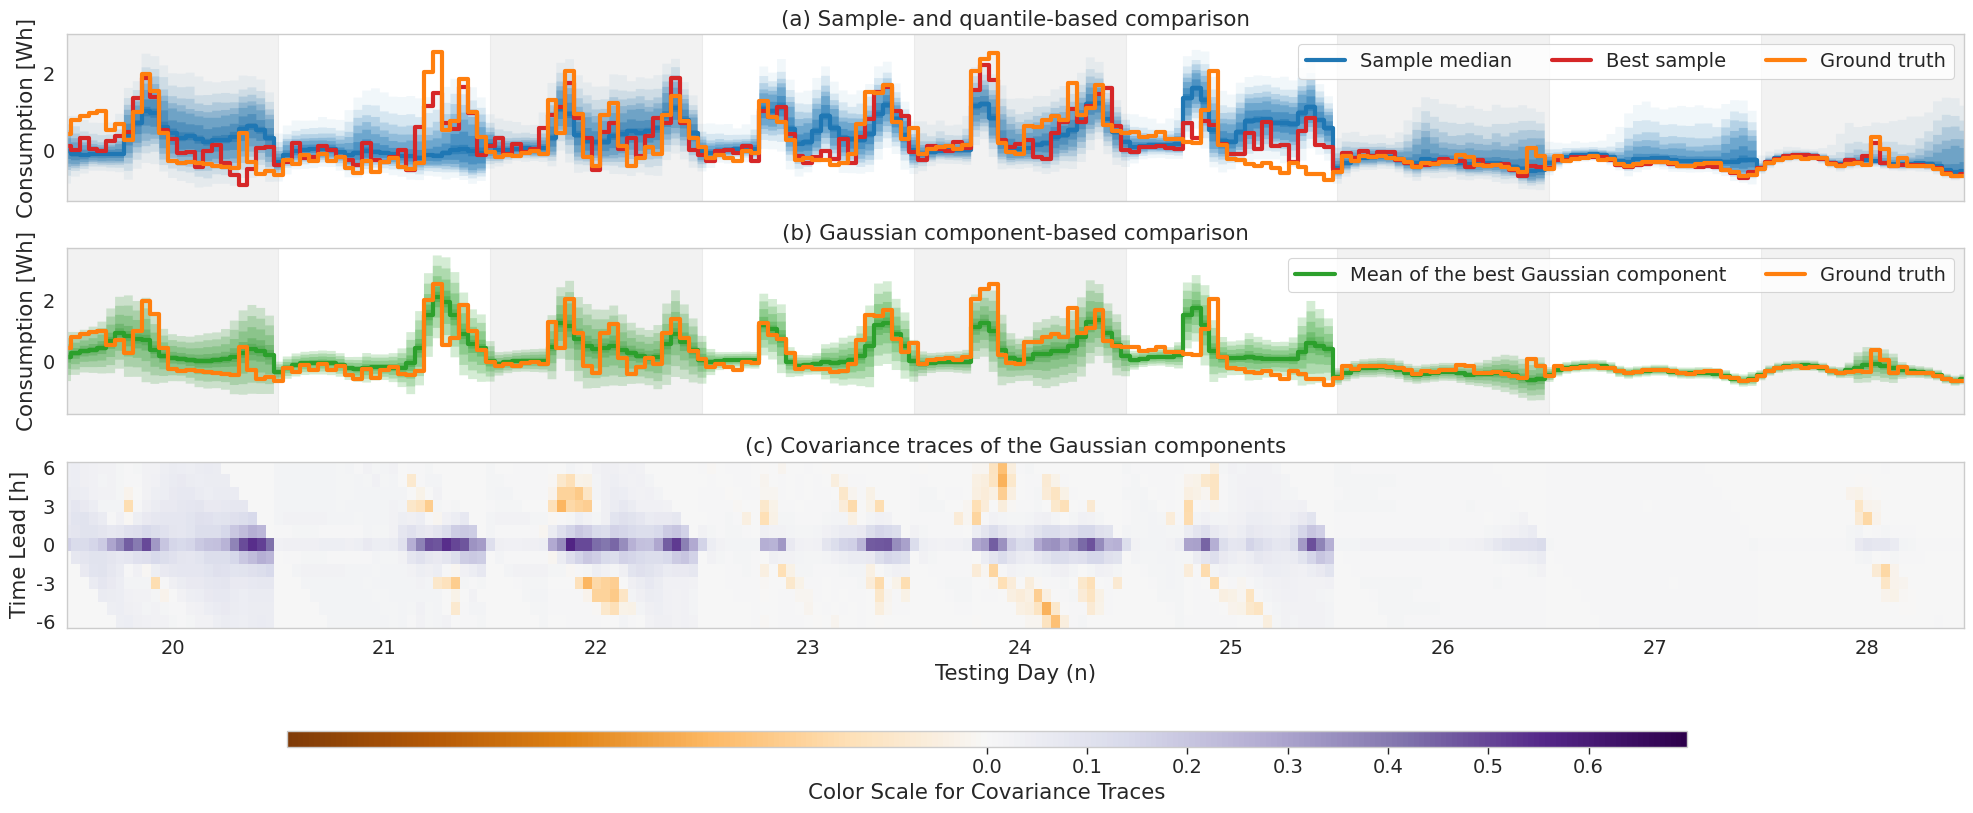

In [156]:
fig, ax = plt.subplots(3,figsize=(20, 8), sharex=True)
# fig.tight_layout()


for q in range(quantiles.__len__()//2):  ax[0].fill_between(np.arange(quantiles_test.shape[-1]),quantiles_test[q,0,:], quantiles_test[-(q+1),0,:], alpha=(1.2*quantiles[q])**(1/1.0), color="tab:blue", lw=0, step="mid")


for i in range(num_viz_samples):
    selected_sample = np.take_along_axis(estimation_samples[:].reshape(num_prior_samples,num_test_days,-1), best_indices_distance[[i]][...,None], axis=0).reshape(-1)

    selected_mu_denorm = np.take_along_axis(estimation_params["mu"][:].reshape(num_prior_samples,num_test_days,-1), best_indices[[i]][...,None], axis=0)
    selected_mu = np.take_along_axis(estimation_params["mu"][:], best_indices[[i]][...,None], axis=0)

    # ax[0].plot(selected_mu_denorm.reshape(-1), label="Best estimation", lw=2, alpha=1, color="tab:green")
    for dev in devs:
        # lower_bound = utils.zero_preserved_log_denormalize(selected_mu-dev*marginal_sigmas_best[i], nonzero_mean, nonzero_std, log_input=log_space).reshape(-1)
        lower_bound = (selected_mu-dev*marginal_sigmas_best[i]).flatten()
        # upper_bound = utils.zero_preserved_log_denormalize(selected_mu+dev*marginal_sigmas_best[i], nonzero_mean, nonzero_std, log_input=log_space).reshape(-1)
        upper_bound = (selected_mu+dev*marginal_sigmas_best[i]).flatten()
        ax[1].fill_between(np.arange(lower_bound.shape[-1]), lower_bound, upper_bound, alpha=1/(dev+3), color="tab:green", lw=0, step="mid")
    
ax[0].step(np.arange(quantiles_test.shape[-1]),quantiles_test[quantiles.__len__()//2,0,:], label="Sample median", color="tab:blue", lw=3, alpha=1, where="mid")
ax[0].step(np.arange(selected_sample.shape[0]), selected_sample, where="mid", lw=3, alpha=1, color="tab:red", label="Best sample")
ax[1].step(np.arange(selected_mu_denorm.reshape(-1).shape[0]), selected_mu_denorm.reshape(-1), where="mid", lw=3, alpha=1, color="tab:green", label="Mean of the best Gaussian component")

#put a gray background every 24 hours
for i in [0,1]:
    ax[i].step(np.arange(X_test_missing_user.flatten().shape[0]), X_test_missing_user.flatten(), where="mid", lw=3, alpha=1.0, color="tab:orange", label="Ground truth")
    ax[i].legend(loc="upper right", ncol=3)
    for j in range(start_day, end_day,2): ax[i].axvspan(num_steps_per_profile*j, num_steps_per_profile*(j+1), color="gray", alpha=0.1)

# Create a common colormap normalization for both imshows
cmap = "PuOr"
norm = mcolors.TwoSlopeNorm(vcenter=0)

# Plot the imshow for axes 1 and 3
im = ax[2].imshow(utils.full_band(block_diag(*[cov_matrices_best[0,i_] for i_ in range(num_test_days)]), k=dependency_lookaway), 
                   cmap=cmap, aspect="auto", interpolation="nearest", norm=norm)

# Set y-ticks for axes 1 and 3
ax[2].set_yticks(np.arange(0, 2*dependency_lookaway + 1, 3))
ax[2].set_yticklabels(np.arange(-dependency_lookaway, dependency_lookaway + 1, 3)[::-1])

# Add a single horizontal colorbar at the bottom
cbar_ax = fig.add_axes([0.15, 0.05, 0.7, 0.02])  # [left, bottom, width, height]
fig.colorbar(im, cax=cbar_ax, orientation="horizontal", label="Color Scale for Covariance Traces")

# Update axis labels and layout
ax[-1].set_xticks(np.arange(1/2*num_steps_per_profile, num_test_days * num_steps_per_profile, num_steps_per_profile))
ax[-1].set_xticklabels(np.arange(0, num_test_days, 1))

for i in [0,1]:
    # ax[i].set_yscale("log")
    # ax[i].set_ylim(2e1, 2e3)
    # ax[i].set_ylim(0, 500)
    ax[i].set_ylabel("Consumption [Wh]")

ax[2].set_ylabel("Time Lead [h]")

titles = ["(a) Sample- and quantile-based comparison", "(b) Gaussian component-based comparison", "(c) Covariance traces of the Gaussian components"]

for i, ax_ in enumerate(ax):
    ax_.set_xlim(num_steps_per_profile * start_day, num_steps_per_profile * end_day - 1)
    ax_.grid(False)
    ax_.set_title(titles[i])


ax[-1].set_xlabel("Testing Day (n)")
fig.tight_layout(rect=[0, 0.1, 1, 1])  # Adjust layout to accommodate colorbar

# plt.savefig("output.png", dpi=300, bbox_inches="tight")

plt.show()